# <center>CSC420 Project  <br><br> DVD Cover Project<br> <br> Student Number: 1002572236 <br><br>Name: Danil Redko</center>


                                                                                           

Let's start by importing the needed libraries:

In [107]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy.spatial.distance import euclidean as euc
import random
from numpy.linalg import eig, svd, norm


In [2]:
cover = cv2.imread('data/DVDcovers/shrek2.jpg')[:,:,::-1]
test = cv2.imread('data/test/image_01.jpeg')[:,:,::-1]

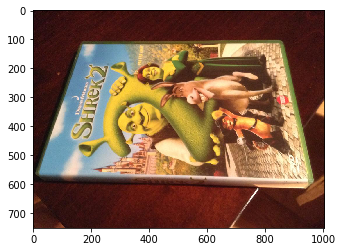

In [3]:
plt.imshow(test)

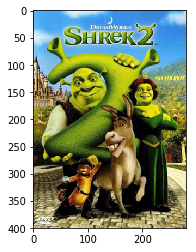

In [4]:
plt.imshow(cover)

In [5]:
def get_interest_points(img):
    img1 = img.copy()
    sift = cv2.xfeatures2d.SIFT_create()
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    kp, des = sift.detectAndCompute(gray, None)

    return cv2.drawKeypoints(gray, kp, img1, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS), kp, des

In [178]:
def matching(img1, img2):
    
    _, kp1, des1 = get_interest_points(img1)
    _, kp2, des2 = get_interest_points(img2)
    match = []
    kp_diff = []

    for j in range(0, len(kp1)):

        for i in range(0, len(kp2)):
            euc_dist = euc(des1[j], des2[i])
            if euc_dist < 100:
                kp_diff.append(euc_dist)
                match.append([kp1[j],kp2[i]])
    
    return np.array(match)




In [19]:
def match_images(img1, img2):
    
    img1_show = img1.copy()
    img2_show = img2.copy()
    
    matches = matching(img1, img2)
    
    kp1, kp2, kp3 = matches[0], matches[1], matches[3]
    
    x1, y1 = kp1[0].pt
    x3, y3 = kp2[0].pt 
    x5, y5 = kp3[0].pt 
    
    x2, y2 = kp1[1].pt
    x4, y4 = kp2[1].pt    
    x6, y6 = kp3[1].pt
    
    
    f = plt.figure(figsize=(20,20))
    f.add_subplot(1,2, 1)
    plt.scatter(x1, y1, color='r', linewidth=50)
    plt.scatter(x3, y3, color='b',  linewidth=50)
    plt.scatter(x5, y5, color='y',  linewidth=50)
    plt.imshow(img1_show)
    f.add_subplot(1,2,2)
    plt.imshow(img2_show)
    plt.scatter(x2, y2, color='r',  linewidth=20)
    plt.scatter(x4, y4, color='b',  linewidth=20)
    plt.scatter(x6, y6, color='y',  linewidth=20)
    

    

We need to compute the homography. 

# Ah = 0 <br>

where $A$ is $2n \times 9$ <br> <br>

$h$ is $9 \times 1$ <br><br>

So we have an equation in the following form : <br><br>

$\begin{bmatrix}
    x_{1} & y_{1} & 1 & 0 & 0 & 0 & -x^{'}_{1}x_{1} & -x^{'}_{1}y_{1} & -x^{'}_{1} \\
    0 & 0 & 0 & x_{1} & y_{1} & 1 & -y^{'}_{1}x_{1} & -y^{'}_{1}y_{1} & -y^{'}_{1} \\
       & & & & &\vdots \\
    x_{n} & y_{n} & 1 & 0 & 0 & 0 & -x^{'}_{n}x_{n} & -x^{'}_{n}y_{n} & -x^{'}_{n} \\
    0 & 0 & 0 & x_{n} & y_{n} & 1 & -y^{'}_{n}x_{n} & -y^{'}_{n}y_{n} & -y^{'}_{n}
\end{bmatrix}$ $\begin{bmatrix} h_{00} \\h_{01}\\h_{02}\\h_{10}\\h_{11}\\h_{12}\\h_{20}\\h_{21}\\h_{22} \end{bmatrix}$ =  $\begin{bmatrix} 0 \\ 0 \\ \vdots \\ 0 \\ 0 \end{bmatrix}$


*Note: 

<br>In the code below: 

$x_i$ corresponds to $x$ <br>

$x_j$ corresponds to $x^{'}$ <br>

Similarly, for y: 

$y_i$ corresponds to $y$ <br>

$y_j$ corresponds to $y^{'}$ <br>


In [20]:
def compute_homography(matches):
    
    '''
    The function computes matrix 3 by 3 - h (homography matrix).
    '''
    
    number_of_matches = len(matches)
    
    #Create an array -  A
    
    A = []
    
    for match in matches:
        
        x_i, y_i = match[0].pt #keypoint in first image 
        x_j, y_j = match[1].pt #keypoint in the second image
        
        row = [x_i, y_i, 1, 0, 0, 0 , -x_j*x_i, -x_j*y_i, -x_j ]
        
        A.append(row)
        
        row = [0, 0, 0, x_i, y_i, 1, -y_j*x_i, - y_j*y_i, -y_j]
        
        A.append(row)
        
    A = np.array(A)
        
    '''
    Solution: h = eigenvector of A.T*A with smallest eigenvalue
    
    Eig returns the normalized (unit “length”) eigenvectors,
    such that the column e_vec[:,i] is the eigenvector corresponding to the eigenvalue e_val[i].
    '''
    
    e_val, e_vec = eig(np.matmul(A.T, A))
   
    h = e_vec[:, np.argmin(e_val)].reshape(3,3)
    
    return h
    

In [204]:
def match_point_homography(x, y, H):
    
    """
    point is a match of on the reference image
    
    H is a homography matrix (given by compute_homography function)
    
    returns a coordinates of the match on the test image
    
    """
    
    #x , y = point[0], point[1]
    
    vector = np.array([x, y , 1.0])
    
    result = np.matmul(H, vector) # Gets a vector of the form [ax', ay', a].T
    
    new_x, new_y , _= result / result[-1]
    
    return new_x, new_y
    

In [93]:
def transform_image(img1, img2, H):
    
    img1x, img1y, _ = img1.shape
    left_up_x, left_up_y = 0, 0
    left_bottom_x, left_bottom_y = 0, img1x
    right_up_x, right_up_y = img1y, 0
    right_bottom_x, right_bottom_y = img1y, img1x
    
    p1 = match_point_homography(0, 0 , H)
    p2 = match_point_homography(0, img1x,H)
    p3 = match_point_homography(img1y, 0, H)
    p4 = match_point_homography(img1y, img1x, H)
    
    f = plt.figure(figsize=(20,20))
    plt.imshow(img2)
    plt.plot((p1[0], p2[0]), (p1[1], p2[1]), c='r', linewidth=5)
    plt.plot((p1[0], p3[0]), (p1[1], p3[1]), c='r', linewidth=5)
    plt.plot((p2[0], p4[0]), (p2[1], p4[1]), c='r', linewidth=5)
    plt.plot((p3[0], p4[0]), (p3[1], p4[1]), c='r', linewidth=5)
   
    

In [46]:
matches = matching(cover, test)

[ 9 10 13]


In [218]:
def RANSAC(matches):

    best_inliers = 0
    
    best_H  = []
    
    for i in range(0, 10000):
                        
        SampleMatches = np.array(random.sample(matches, 4))
        
        H = compute_homography(SampleMatches)
        
        inliers = 0 
        
        for match in SampleMatches:
            
            x_i, y_i = match[0].pt #keypoint in first image
            
            new_x_i , new_y_i = match_point_homography(x_i, y_i, H)
            
            x_j, y_j = match[1].pt #keypoint in the second image
                        
            dist = norm(np.array([x_j - new_x_i, y_j - new_y_i]))
            
            if dist < 0.000000005:
                     
                inliers += 1
        
        if inliers > best_inliers:
            
            best_inliers = inliers 
            
            best_H = H
            
    return best_H
       

In [223]:
H = RANSAC(matches)

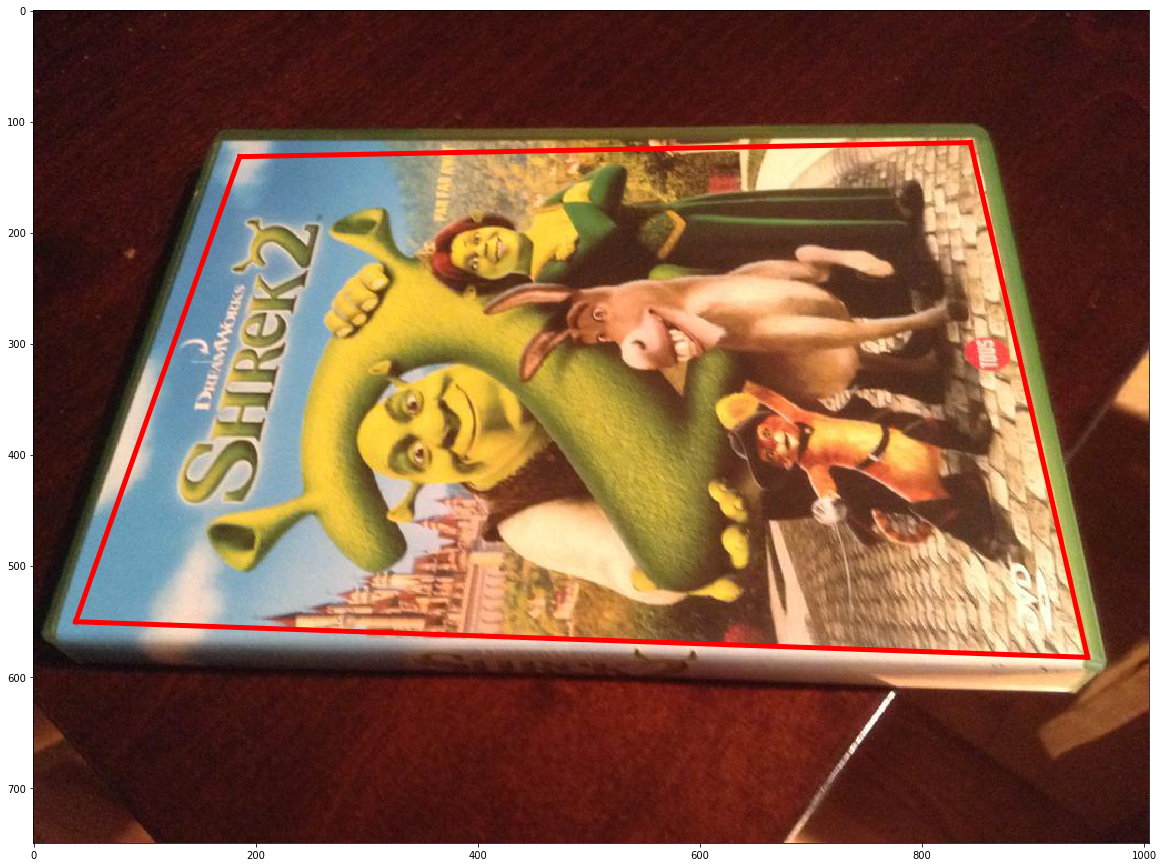

In [224]:
transform_image(cover, test, H)